<a href="https://colab.research.google.com/github/rahul-premanand/Hello-World/blob/main/xg_boost_assip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
#!pip install shap

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import shap
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [ ]:
# Load the data
filepath = "/content/drive/MyDrive/assip_data/new_daily_air_data_merged.csv"
df = pd.read_csv(filepath)

# Drop rows with missing values
df = df.dropna()

# Print column names
print(df.columns)
print(df['County Name'].unique())

In [ ]:
available_counties = df['County Name'].unique()
print("Available counties:", available_counties)

# Let's choose a few random counties for the example
specified_counties = available_counties[:6]  # Choosing the first 6 available counties
df_selected = df[df['County Name'].isin(specified_counties)]

# Print unique counties in the filtered dataset
print(df_selected['County Name'].unique())

In [ ]:

# Select features and target variable, excluding the 'County Name' column during training
X = df_selected.drop(columns=['AQI', 'Latitude', 'Longitude', 'County Name', 'State Name', 'City Name', 'Address', 'Date Local', 'Unnamed: 0'])
y = df_selected['AQI']

# Ensure all feature columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Ensure target variable has no NaN or infinite values
y = y.replace([float('inf'), -float('inf')], float('nan')).dropna()

# Align features and target to have matching indices
X, y = X.align(y, join='inner', axis=0)

print("Features and target selected successfully.")


# Print the first few rows of the features and target
print(X.head())
print(y.head())

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training and testing sets created successfully.")
params = {"learning_rate": 0.01, "max_depth": 4}
dtrain = xgb.DMatrix(X_train, label=y_train)
bst = xgb.train(params, dtrain, num_boost_round=1000)

# Testing the XGBoost model
dtest = xgb.DMatrix(X_test)
y_pred = bst.predict(dtest)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")








In [ ]:
# Calculate feature importance
importance_df = pd.DataFrame({
    'Feature': bst.get_score(importance_type='weight').keys(),
    'Importance': bst.get_score(importance_type='weight').values()
}).sort_values(by='Importance', ascending=False)

print("XGBoost Feature Importances:")
print(importance_df)


SHAP Feature Importances:
                Feature  Importance
16          County Code   21.378869
17        1st Max Value   19.929934
9     Observation Count   10.896836
1       Arithmetic Mean    6.059001
4          1st Max Hour    5.142812
0        Parameter Code    5.097816
20             Site Num    0.571388
13                  POC    0.389148
14  Observation Percent    0.371128
15          Method Code    0.235943
19           State Code    0.142688
7       Local Site Name    0.000000
8             CBSA Name    0.000000
6                 Datum    0.000000
5      Units of Measure    0.000000
11   Pollutant Standard    0.000000
12          Method Name    0.000000
3        Parameter Name    0.000000
2       Sample Duration    0.000000
18           Event Type    0.000000
10  Date of Last Change    0.000000


/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


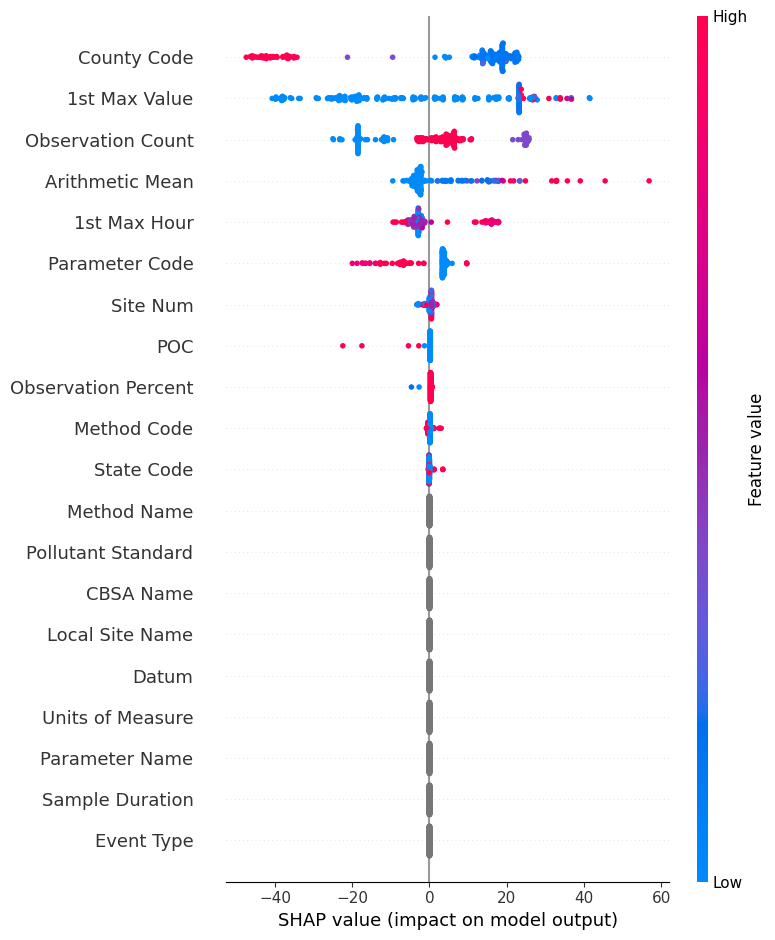

TypeError: loop of ufunc does not support argument 0 of type Explanation which has no callable conjugate method

In [ ]:
# Initialize the SHAP explainer
explainer = shap.Explainer(bst, X_train)

# Calculate SHAP values
shap_values = explainer(X_test)


# Initialize the SHAP explainer
explainer = shap.Explainer(bst, X_train)

# Calculate SHAP values
shap_values = explainer(X_test)


# Get the feature importances from SHAP values
shap_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.mean(np.abs(shap_values.values), axis=0)
}).sort_values(by='Importance', ascending=False)

print("SHAP Feature Importances:")
print(shap_importance_df)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test)
plt.show()


# Ensure the feature exists in X_test
feature = "County Code"
if feature in X_test.columns:
    # Plot SHAP dependence plot for a specific feature
    shap.dependence_plot(feature, shap_values, X_test)
    plt.show()
else:
    print(f"Feature '{feature}' is not in X_test columns.")

In [ ]:
shap.plots.bar(shap_values)